# Szalka Áron Beszámoló Python kurzus Szisz
A beszámómban az IMDB top 1000-es listáján található filmeken dolgozó emberek közti hálózati kapcsolatot vizsgáltam meg. Ehhez scrapeltem ennek az 1000 filmnek az adatlapját, letöltöttem a filmen dolgozó stában és a főbb színészeknek a neveit és ezeket egy Pandas adatbázisba gyűjtöttem, körülbelül 11000 nevet. Ezt követően megvizsgáltam a közöttük lévő kapcsolatot, ami azt jelenti, hogy dolgoztak-e közösen filmen. Ezenfelül kiszámoltam mindegyik Bacon-számát, ami azt jelenti, hogy hány lépésre vannak Kevin Bacon-től. Végül Leszűrtem az adatbázist, úgy hogy csak azok maradjanak benne, akik az 1000-ből legalább 10 filmen dolgoztak, mert ők vannak körülbelül annyian, amennyit egy gráf még nagyjából átláthatóan elbír. (Ez gyakorlatilag ugyanaz, mint ha a kollégális kapolcsatok alapján rangsoroltam volna őket és a felsőket választottam volna ki, mert minden filmhez körülbeülül ugyanannyi embert töltöttem le, azon belül pedig definíció szerint teljes gráf áll fenn). Végül őket egy gráfba rendeztem, amelyet kiszíneztem foglalkozási terület szerint is, és amelyben az emberek gráfpontjainak mérete arányos azzal, hogy ebben az elit ligában hány kapcsolatuk van. A beszámoló igazi outputja egy PDF, amelyben a gráf jól kivehetően megjelenik, ezt ccsatolom a beszámolóhoz, de újra futtava is kijön. A tanulság, hogy megelpően sok zeneszerző van a "pókháló" közepe felé, és hogy Harvey Weinstein valóben megkerülhetetlen figura volt Hollywoodban, hozzá fut be a legtöbb él.

megjegyzés: a beszámolót még a ChatGPT megjelenése előtt írtam és ez volt az első önálló munkám, így nem minden megoldás elegáns benne de minden működik

In [141]:
import requests
from IPython.display import HTML
from bs4 import BeautifulSoup
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from ast import literal_eval
import json
import graphviz
from graphviz import Digraph
from graphviz import Graph
import pydot
import sys
from networkx.drawing.nx_agraph import graphviz_layout

Első lépésként az imdb top 1000-es listájának (népszerűség szerint rendezve) filmjeihez tartozó url-eket scrapeltem le és gyűjtöttem listába. Az 1000-es lista 20 oldalból állt, mindben 50 film szerepelt. A kód végigfut az oldalakon, és mindből kiszedi a filmhez tartozó imdb azonosítót, amit utána behelyettesít a standard imdb- urljébe kiegészítve azzal, hogy a sime filmoldal helyett a részletes stáblista oldalára mutasson az url.

In [143]:
urls = []

for e in range(0,19,1):
    if e == 0:
        kiegészítés = ''
    else:
        kiegészítés = 'start={}&'.format(str(50*e+1))
    
    existing_url = 'https://www.imdb.com/search/title/?groups=top_1000&view=simple&sort=user_rating,desc&{}ref_=adv_nxt'.format(kiegészítés)
    response = requests.get(existing_url)
    document = response.content
    soup = BeautifulSoup(document, 'html.parser')

    filmlista = soup.find(class_="lister-list").find_all('a')
    segéd = []
    segéd2 = []


    for i in filmlista:
        if 'title' in i.get('href'):
            segéd += [i]

    for j in range(0, len(segéd), 1):
        if j % 2 == 1:
            segéd2 += [segéd[j]]

    for k in segéd2:
        urls += ['https://www.imdb.com{}fullcredits/?ref_=tt_ov_st_sm'.format(k.get('href'))]
        

A filmek stáblista oldalait egyesével scrapeltem le. A szereplőket a nagylista nevű listába gyűjtöttam amely első eleme a színész vagy stábtag neve, a második a foglalkozása, a harmadik pedig egy egy elemű lista ami a film címét tartalmazza. A színészek és a többi stábtag különböző módokon volt a filmek oldaláb, így rájuk külön függvényt írtam. A nehézséget az okozta, hogy sokszor nem votlak a neveket tartalmaozó cellák jól identifikálhatóak, és egymással megegyeztek ezért a közelükben lévő identifikálható cellát kerestem meg és onnan lépkedtem le, a színészek esetén pedig ugyanez volt a helyzet, közülük mindig a legfelső 5-öt töltöttem le, mert stáblista szerint rendezi őket az imdb, tehát fontossági sorrendben.

In [89]:
szakmák = ['director', 'writer', 'producer', 'composer', 'cinematographer', 'editor']

In [123]:
def szakemberek(x,y):
    táblák = y.find('div', id='fullcredits_content').find('h4', id=x).findNext('table').find_all('a')
    táblákösszerakott = []
    for i in táblák:
        táblákösszerakott += [i.get_text()]
    adottstáblista = []
    for i in táblákösszerakott:
        adottstáblista += [i[1:-1]]
    return adottstáblista

In [124]:
#színészek esetén

def színészek(soup2):
    színészlista = []
    színészlista += [soup2.find('table', class_='cast_list').find('tr', class_='odd').find('td').findNext('td').find('a').get_text()]
    színészlista += [soup2.find('table', class_='cast_list').find('tr', class_='odd').findNext('tr').find('td').findNext('td').find('a').get_text()]
    színészlista += [soup2.find('table', class_='cast_list').find('tr', class_='odd').findNext('tr').findNext('tr').find('td').findNext('td').find('a').get_text()]
    színészlista += [soup2.find('table', class_='cast_list').find('tr', class_='odd').findNext('tr').findNext('tr').findNext('tr').find('td').findNext('td').find('a').get_text()]
    színészlista += [soup2.find('table', class_='cast_list').find('tr', class_='odd').findNext('tr').findNext('tr').findNext('tr').findNext('tr').find('td').findNext('td').find('a').get_text()]
    
    javítottlista = []
    for i in színészlista:
        javítottlista += [i[1:-1]]
    return javítottlista

In [125]:
nagylista = []
for i in urls:  
    response2 = requests.get(i)
    document2 = response2.content
    soup2 = BeautifulSoup(document2, 'html.parser')

    cim = soup2.find('div', class_='parent').find('a').get_text()

    for i in szakmák:
        try:
            for j in range(0, len(szakemberek(i, soup2)),1):
                nagylista = nagylista +[[szakemberek(i,soup2)[j], i, [cim]]]
        except:          
            pass
        
    for i in range(0,5,1):
        try:
            nagylista += [[színészek(soup2)[i], 'actor', [cim]]]
        except:
            pass

Az így kapott nagylista még nem volt kielégítő, mert azok, akik több filmen is dolgoztak, annyiszor szerepeltek is a listában, mindig az adott filmcímmel. Ezért készítettem egy javított listát, ami végigment a nagylistán és ha olyan embert talált, aki már szerepelt, akkor nem írta be újra, hanem csak hozzáadta az emberhez tartozó filmlistához az új filmet is. Így kaptam egy olyan listát, ahol minden ember csak egyszer szerepel, viszont a hozzá tartozó lista tartalmazza az összes filmet, amin dolgozott. Annak, hogy így az ember munkaköre nem lesz jól definiált nem tulajdonítottam jelentőséget, mert nagyon ritka az, hogy valaki többféle munkakörben is dolgozzon top 1000-es filmeket, így mindenki azon a munkakörben került be a végső listára, amibena  program először megtalálta (bár Clint Eastwood pl színészként és rendezőként is híres lett). Az így kapott listát ki is mentettem hogy ne kelljen többször megvárnaom a scrapelést.

In [131]:
javítottlista = []
for i in nagylista:
    l = False
    for k in range(0,len(javítottlista),1):
        if  javítottlista[k][0] == i[0]:
            l = True
            if i[2][0] not in javítottlista[k][2]:
                javítottlista[k][2] = javítottlista[k][2] + [i[2][0]]
    if l == False:
        javítottlista += [i]

In [134]:
with open('javítottlista.json', "w") as f:
    json.dump(javítottlista, f)

In [143]:
with open('javítottlista.json') as f:
    javítottlista = json.load(f)

A következő szakaszban kiszámoltam mindenkinek a Bacon-számát. Minden emberhet (akik ugye egy listák a listában sőt a filmjeik még abban is egy listák), hozzáadtam még egy elemet, a Bacon számot. Kezdetben ezt mindenkinél -1-re állítottam, kivéve Bacont, akinél 0-ra.

In [144]:
for i in javítottlista:
    i += [-1]


In [146]:
for i in javítottlista:
    if i[0] == 'Kevin Bacon':
        i[3] = 0
        
for i in javítottlista:
    if i[0] == 'Kevin Bacon':
        print(i)

['Kevin Bacon', 'actor', ['Titokzatos folyó', 'X-Men: Az elsők', 'Frost/Nixon', 'Egy becsületbeli ügy'], 0]


Ezt követően végigfuttattam a listán a kódot. A logikája az, hgy egyre nagyobb bacon számokat keres, a kicsiktől indul. Végigmegy a lista elemein, és minden elemhez, akinél a bacon szám -1, végigmegy a lista elemein. Ha talál olyat, akinek a bacon száma egyel kisebb, mint amit éppen keresünk, akkor megnézi, hogy a két ember dolgozott e közösen filmen (vagyis összehasonlítja a filmlistájukat hogy van e közös eleme). ha igen az adott ember bacon száma, amit éppen kerestünk.

In [150]:
for x in range(1, 15, 1):
    for i in javítottlista:
        if i[3] == -1:
            for j in javítottlista:
                if j[3] == x-1:
                    for k in i[2]:
                        for l in j[2]:
                            if k == l:
                                i[3] = x 

A kész listát egy pandas dataframe-be mentettem és kimentettem csv formátumba biztonsági mentésnek.

In [152]:
df = pd.DataFrame(javítottlista, columns = ['név', 'foglalkozás', 'filmek','Baconszám'])     
df.to_csv('adatok.csv', index = False)

In [6]:
df = pd.read_csv('adatok.csv', converters = {'filmek': literal_eval})
df

,név,foglalkozás,filmek,Baconszám
0,Frank Darabont,director,"[A remény rabjai, Halálsoron]",2
1,Stephen King,writer,"[A remény rabjai, Halálsoron, Ragyogás, Állj m...",2
2,Liz Glotzer,producer,"[A remény rabjai, Mielőtt éjfélt üt az óra, Vá...",2
3,David V. Lester,producer,"[A remény rabjai, Serenity]",2
4,Niki Marvin,producer,[A remény rabjai],2
...,...,...,...,...
10866,Frank Griebe,cinematographer,[A lé meg a Lola],4
10867,Mathilde Bonnefoy,editor,[A lé meg a Lola],4
10868,Herbert Knaup,actor,[A lé meg a Lola],4
10869,Nina Petri,actor,[A lé meg a Lola],4


Az adott dataframe-et leszűrtem a szerint, hogy az emberek filmlistája milyen hosszú, mert több, mint 10000-en voltak, amit nem lehet ábrázolni. Végül azokat választottam ki, akik több, mint 10 filmen dolgoztak, de ezt át lehet állítani adott esetben.

In [65]:
# opcionálisan kiszűrni azokat, akik csak egy filmben szerepeltek, mert különben átláthatatlanul sokan vannak

df = df[df['filmek'].map(lambda d: len(d)) > 10]
df

,név,foglalkozás,filmek,Baconszám
5,Thomas Newman,composer,"[A remény rabjai, Halálsoron, Wall-E, 1917, Am...",2
6,Roger Deakins,cinematographer,"[A remény rabjai, 1917, Egy csodálatos elme, F...",2
23,Al Pacino,actor,"[A keresztapa, A keresztapa II, A sebhelyesarc...",2
41,Hans Zimmer,composer,"[A sötét lovag, Eredet, Csillagok között, Glad...",1
54,Robert De Niro,actor,"[A keresztapa II, Nagymenők, Joker, Volt egysz...",2
79,Bob Weinstein,producer,"[A Gyűrűk Ura: A király visszatér, Ponyvaregén...",2
80,Harvey Weinstein,producer,"[A Gyűrűk Ura: A király visszatér, Ponyvaregén...",2
81,Howard Shore,composer,"[A Gyűrűk Ura: A király visszatér, A Gyűrűk Ur...",2
102,Steven Spielberg,director,"[Schindler listája, Ryan közlegény megmentése,...",2
106,Kathleen Kennedy,producer,"[Schindler listája, Vissza a jövőbe, Hatodik é...",3


Későbbi gráfok közül van, amelyiknél úgy volt egyszerűbb megoldani valamit számomra, a sorokra szedtem az adatbázist egy külön változóba, és ha az adatbázis oszlopait is külön listákba szedem új változókba

In [144]:
sorlisták =[] 
  
# Iterate over each row 
for index, sorok in df.iterrows(): 
    my_list =[sorok.név, sorok.foglalkozás, sorok.filmek] 
    sorlisták.append(my_list)

In [8]:
df2 = df['név'].tolist()
df3 = df['foglalkozás'].tolist()
df4 = df['filmek'].tolist()

Készítettem egy listát a szűrt adatbázisra, amely minden kollegális viszonyt egy külön kis 2 elemű listába szed, hogy később a gráfom éleit könnyebblegyen megvalósítani. Ez végigmegy minden emberen, és mindhez újra minden emberen és utána minde a kettőnek a saját filmlistáján, hogy összehasonlítsa, van e közös elemük, vagyis dolgoztak- e mindketten egy filmen, és ha igen egy párkéntkülön kis listában hozzáadja őket a kollegális listához. Ezt követően még ki kellett szűni azt, amikor valakit saját maga kollegájaként került a listába és azt is amikor ugynaz a két ember, csak fordított sorrendben. A végső kész lista a kollegák 4 lista. Ezt ki is mentettem egy külön fájlba, majd mikor behívtam már élek néven neveztem el.

In [11]:
#ez a lista adja meg a párokat, akik már dolgoztak közös filmen

kollegák = []
kollegák2 = []
kollegák3 = []
kollegák4 = []

for i in range(0, len(df4), 1):
    for j in range(0, len(df4), 1):
        for k in range(0, len(df.iloc[i]['filmek']), 1):
            for l in range(0, len(df.iloc[j]['filmek']), 1):
                if df.iloc[i]['filmek'][k] == df.iloc[j]['filmek'][l]:
                    kollegák += [[df.iloc[j]['név'],df.iloc[i]['név']]]
                       
for i in kollegák:
    if i[0] != i[1]:
        kollegák2.append(i)

for i in kollegák2:        
    if [i[1],i[0]] not in kollegák3:
        kollegák3.append(i)
        
for i in kollegák3:        
    if [i[0],i[1]] not in kollegák4:
        kollegák4.append(i)    
    

[['Roger Deakins', 'Thomas Newman'], ['Al Pacino', 'Thomas Newman'], ['Steven Spielberg', 'Thomas Newman'], ['Michael Kahn', 'Thomas Newman'], ['Tom Hanks', 'Thomas Newman'], ['John Lasseter', 'Thomas Newman'], ['Hans Zimmer', 'Roger Deakins'], ['Steven Spielberg', 'Roger Deakins'], ['James Horner', 'Roger Deakins'], ['Carter Burwell', 'Roger Deakins'], ['Scott Rudin', 'Roger Deakins'], ['Tim Bevan', 'Roger Deakins'], ['Eric Fellner', 'Roger Deakins'], ['Robert De Niro', 'Al Pacino'], ['Arnon Milchan', 'Al Pacino'], ['Bob Weinstein', 'Hans Zimmer'], ['Harvey Weinstein', 'Hans Zimmer'], ['Leonardo DiCaprio', 'Hans Zimmer'], ['Arnon Milchan', 'Hans Zimmer'], ['Brad Pitt', 'Hans Zimmer'], ['Tim Bevan', 'Hans Zimmer'], ['Eric Fellner', 'Hans Zimmer'], ['Bob Weinstein', 'Robert De Niro'], ['Harvey Weinstein', 'Robert De Niro'], ['Arnon Milchan', 'Robert De Niro'], ['Ennio Morricone', 'Robert De Niro'], ['Robert Richardson', 'Robert De Niro'], ['Harvey Weinstein', 'Bob Weinstein'], ['Howard 

In [14]:
with open('kollegák.json', "w") as f:
    json.dump(kollegák4, f)

In [64]:
with open('kollegák.json') as f:
    élek = json.load(f)

Ez követte magának a gráfnak a megvalósítása. Először is definiáltam két függvényt. Az egyik egy színt ad kiattól függően, hogy a betáplát ambernek mi a foglalkozása, a másik pedig egy méretfüggvény, amely annak másodfokú függvényében ad számot, hogy a betáplát embernek hány kapcsolata van a szűkített mintáben. Vagyis az elit elitjében is kik állnak a középpontban.

In [78]:
def szín(i):
    if i[1] == 'director':
        return 'yellow'
    elif i[1] == 'writer':
        return 'green'
    elif i[1] == 'producer':
        return 'purple'
    elif i[1] == 'composer':
        return 'red'
    elif i[1] == 'cinematographer':
        return 'brown'
    elif i[1] == 'actor':
        return 'blue'
    else: #editor
        return 'gray'

In [136]:
def méret(i):
    k = 0
    for j in élek:
        if i[0] in j:
            k += 1
    l = k**0,1+k*0.2+1
    return l

Ezt követte maga a gráf. Beállítottam azokat a peremétereket, amelyekkel úgy éretem jól néz ki de ennyi ember esetén sem könnyű átlátni. Az megállapítható, hogy viszonylag elszórt a mezőny a foglalkozásokat tekintve. A legtöbben a producerek vannak, de ez nem is meglepő mert a legtöbb filmen több producer is dolgozik. Engem jobban meglepett hogy a zeneszerzők milyen sokan vannak a gráfban és jóval kevesebb színész mint gondoltam volna. Továbbá megfigyelhető az ábrán, hogy Harvey Weinstein valóban egy rendkívül fontos ember volt a filmvilágban, hozzá fut be még ebben a válogatott mezőnyben is az egyik legtöbb él, ezáltal az ő pontja az egyik legnagyobb. A grág pdf foprmában mentésre kelül megnyitáskor.

In [149]:
u = Graph('unix', filename='gráf.gv',
            node_attr={ 'style': 'filled'})
u.attr(size='6,6')


for i in sorlisták:
    u.node(i[0],
           fillcolor = szín(i),
           color = 'black',
           fontsize = '23.0',
           fontname = 'Helvetica',
           height = '{}'.format(str(méret(i))),
           width = '{}'.format(str(méret(i)))
          )


for i in élek:
    u.edge(i[0], i[1])


u.view()

'gráf.gv.pdf'

# A beszámoló eddig tartott

Itt pedig csak mellékesen itthagytam a networkx-ben megcsinált gráfomat, de azt nem lehetettt rendesen vizualizálni. Ezek már nem fontos részei a beszámolónak. Köszönöm a figyelmet!

In [53]:
G = nx.Graph()

for i in df2:
    G.add_node(i)

for i in élek:
    G.add_edge(i[0],i[1])
      
color_map = []
for i in df3:
    if i == 'director':
        color_map.append('yellow')
    elif i == 'writer':
        color_map.append('green')
    elif i == 'producer':
        color_map.append('purple')
    elif i == 'composer':
        color_map.append('red')
    elif i == 'cinematographer':
        color_map.append('brown')
    elif i == 'actor':
        color_map.append('blue')
    else: #'editor'
        color_map.append('gray')
        

d = dict(G.degree)


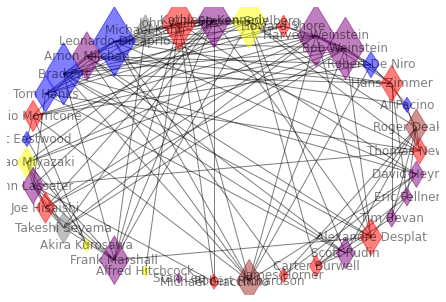

<Figure size 93600x93600 with 0 Axes>

In [51]:
#kirajzolja a gráfot és kiszínezi foglalkozások szerint

nx.draw_shell(G, nodelist=d.keys(), node_shape="d", alpha=0.5, node_color=color_map, node_size=[(v ** 3 + 13 * v + 50) for v in d.values()], with_labels = True)
#plt.figure(figsize=(3240,3240))
plt.figure(100000,figsize=(1300,1300))
plt.show()



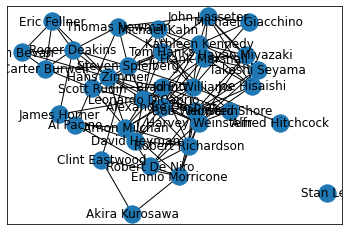

In [23]:
pos = nx.nx_pydot.graphviz_layout(G)
nx.draw_networkx(G, pos)
plt.savefig('networkx_graph.pdf', view = True)